## Additional changes
I have used CNN as classifier, but this kernel use CAM(Class Activation Map) as classifier and Activation feature map. 
Most of them are same, Little different at Network. and than we can see how CAM activate.


## Introduction
Hi, It's my first dataset kernel. <br>
This kernel forked from WM-811k Wafermap[https://www.kaggle.com/ashishpatel26/wm-811k-wafermap].<br>
This dataset has various wafer resolution with class imbalanced. so I just consider specific subset wafer that has 26x26 resolution.<br> 
and solve imbalance problem using 2D convolutional autoencoder. then, classfy faulty case labels.

In [1]:
import os
from os.path import join

import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

datapath = join('data', 'wafer')

print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


['LSWMD.pkl']


### Read data

In [2]:
df=pd.read_pickle("../input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
waferMap          811457 non-null object
dieSize           811457 non-null float64
lotName           811457 non-null object
waferIndex        811457 non-null float64
trianTestLabel    811457 non-null object
failureType       811457 non-null object
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


* The dataset comprises **811,457 wafer maps**, along with additional information such as **wafer die size**, **lot name** and **wafer index**. 

* The training / test set were already split by domain experts, but in this kernel we ignore this info and we re-divided the dataset into training set and test set by hold-out mehtod which will be introduced in later section.

>Target distribution

In [3]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [4]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


* The dataset were collected from **47,543 lots** in real-world fab. However, **47,543 lots x 25 wafer/lot =1,157,325 wafer maps ** is larger than **811,457 wafer maps**. 

* Let's see what happened. 

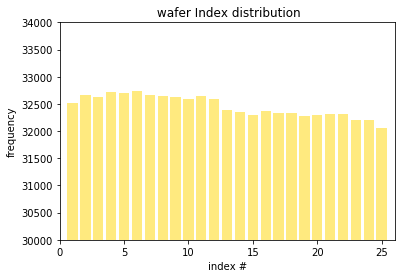

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

* The figure shows that not all lots have perfect 25 wafer maps and it may caused by **sensor failure** or other unknown problems.

* Fortunately, we do not need wafer index feature in our classification so we can just drop the variable. 

In [6]:
df = df.drop(['waferIndex'], axis = 1)

* We can not get much information from the wafer map column but we can see the die size for each instance is different. 

* We create a new variable **'waferMapDim'** for wafer map dim checking.


In [7]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
701495,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2,...",516.0,lot43084,[[Training]],[[none]],"(25, 27)"
308845,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",1139.0,lot18812,[],[],"(38, 38)"
252031,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",518.0,lot15634,[[Training]],[[none]],"(25, 26)"
10306,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2268.0,lot1909,[],[],"(52, 55)"
229084,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5633.0,lot14361,[],[],"(88, 81)"


## Get sub wafer with specific resolution.
get wafers have (26, 26) resolution. rarrange wafer nd-array with fautly case label.<br>
some wafer has null label, skip it.

In [8]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [9]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [10]:
mask_x = np.zeros((24, 24))
dummy_x = cv2.resize(x[0], (24,24))
mask_x[dummy_x == 1] = 1 
mask_x[dummy_x == 2] = 1 
mask_x = mask_x.reshape((1, 24,24))

In [11]:
# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


plot 1st data for check.

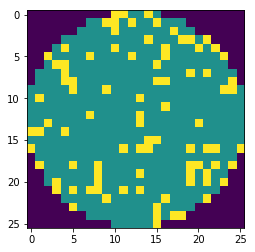

Faulty case : ['none'] 


In [12]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

We will use 2D Convolutional Autoencoder, extend dimension for channel.

In [13]:
#add channel
x = x.reshape((-1, 26, 26, 1))

Make faulty case list, and check how classes imbalanced.

In [14]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [15]:
faulty_case_dict =dict()

In [16]:
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y[y==f])))
    faulty_case_dict[i] = f

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


Wafer data's each pixels have a categorical variable that express 0 : not wafer, 1 : normal, 2 : faulty. <br>
Extend extra dimension with one-hot-encoded categorical data as channel. <br>
**that idea from Data Science & Business Analytics Lab, School of Industrial Management Engineering, College of Engineering, Korea University**[http://dsba.korea.ac.kr/main]

In [17]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [18]:
#check new x dimension
new_x.shape

(14366, 26, 26, 3)

## Convolutional Autoencoder for augmentation.
As solving class imbalanced problem, we need for data augmentation. <br>
The wafer data is image data. so we use convolutional autoencoder.

In [19]:
# parameter
epoch=15
batch_size=1024

In [20]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

Instructions for updating:
Colocations handled automatically by placer.


Check summary

In [21]:
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________________


In [22]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
 - 5s - loss: 0.1519
Epoch 2/15
 - 1s - loss: 0.0949
Epoch 3/15
 - 1s - loss: 0.0834
Epoch 4/15
 - 1s - loss: 0.0724
Epoch 5/15
 - 1s - loss: 0.0634
Epoch 6/15
 - 1s - loss: 0.0562
Epoch 7/15
 - 1s - loss: 0.0504
Epoch 8/15
 - 1s - loss: 0.0456
Epoch 9/15
 - 1s - loss: 0.0409
Epoch 10/15
 - 1s - loss: 0.0363
Epoch 11/15
 - 1s - loss: 0.0321
Epoch 12/15
 - 1s - loss: 0.0287
Epoch 13/15
 - 1s - loss: 0.0259
Epoch 14/15
 - 1s - loss: 0.0235
Epoch 15/15
 - 1s - loss: 0.0216


In [23]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

In [24]:
# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [25]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

In [26]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

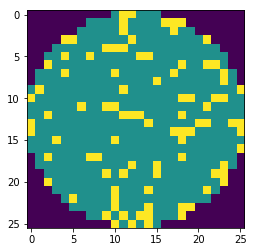

In [27]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

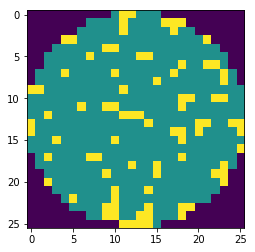

In [28]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

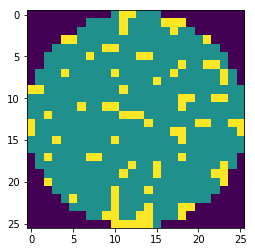

In [29]:
# check reconstructed original faulty wafer data
gen_x = np.argmax(ae.predict(new_x), axis=3)
plt.imshow(gen_x[3])

## Data augmentation
We made convolutional autoencoder model for data augmentation.<br>
I just want data has 2000 samples for each case. Let's augment data for all faulty case.

In [30]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [31]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [32]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (30707, 26, 26, 3), new_y shape : (30707, 1)


In [33]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [34]:
# choice index without replace.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [35]:
# delete choiced index data.
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [36]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)


In [37]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


In [38]:
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

In [39]:
# split data train, test
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [40]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (13203, 26, 26, 3), y : (13203, 9)
Test x: (6504, 26, 26, 3), y : (6504, 9)


## Class Activation Map Model
The data is ready. As wafer data is image. simply use cnn for classification.<br>

### Make model
define create model function, because we will validate model with sklearn kfold cross validation.

In [41]:
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)

def create_model():
    global input_tensor
    
    conv = layers.Conv2D(32, (3,3), activation='relu', name='conv1')(input_tensor)
    padding = layers.ZeroPadding2D(padding=(1, 1), name='padding1')(conv)
    conv = layers.Conv2D(64, (3,3), activation='relu', name='conv2')(padding)
    padding = layers.ZeroPadding2D(padding=(1, 1), name='padding2')(conv)
    conv = layers.Conv2D(128, (3,3), activation='relu', name='conv3')(padding)
    padding = layers.ZeroPadding2D(padding=(1, 1), name='padding3')(conv)
    conv_out = layers.Conv2D(256, (3,3), activation='relu', name='conv4')(padding)

    gap_layer = layers.GlobalAveragePooling2D(name='GAP')
    output_layer = layers.Dense(9, activation='softmax', name='output')

    aver_pool = gap_layer(conv_out)
    output_tensor = output_layer(aver_pool)

    model = models.Model(input_tensor, output_tensor)

    model.compile(optimizer='Adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

    return model

### Cross validate model
Using sklearn KFold Cross validation, we validate our simple cnn.

In [42]:
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Class Activation Map Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/10
 - 4s - loss: 1.9540 - acc: 0.2496
Epoch 2/10
 - 1s - loss: 1.4262 - acc: 0.4221
Epoch 3/10
 - 1s - loss: 1.3113 - acc: 0.4802
Epoch 4/10
 - 1s - loss: 1.2073 - acc: 0.5174
Epoch 5/10
 - 1s - loss: 1.1383 - acc: 0.5477
Epoch 6/10
 - 1s - loss: 1.0533 - acc: 0.5854
Epoch 7/10
 - 1s - loss: 0.9882 - acc: 0.6225
Epoch 8/10
 - 1s - loss: 0.9442 - acc: 0.6317
Epoch 9/10
 - 1s - loss: 0.8902 - acc: 0.6658
Epoch 10/10
 - 1s - loss: 0.8692 - acc: 0.6709
Epoch 1/10
 - 2s - loss: 1.9028 - acc: 0.2850
Epoch 2/10
 - 1s - loss: 1.4078 - acc: 0.4240
Epoch 3/10
 - 1s - loss: 1.2937 - acc: 0.4660
Epoch 4/10
 - 1s - loss: 1.2071 - acc: 0.4926
Epoch 5/10
 - 1s - loss: 1.1343 - acc: 0.5464
Epoch 6/10
 - 1s - loss: 1.0865 - acc: 0.5805
Epoch 7/10
 - 1s - loss: 1.0299 - acc: 0.6020
Epoch 8/10
 - 1s - loss: 0.9818 - acc: 0.6220
Epoch 9/10
 - 1s - loss: 0.9176 - acc: 0.6519
Epoch 10/10
 - 1s - loss: 0.9856 - acc: 0.6292
Epoch 1/10
 - 2s - loss: 1.8840 - acc: 0.2682
Epoch 2/10
 - 1s - loss: 1.4086 

Our model seems quite a good model.

In [43]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=50,
         batch_size=batch_size,
         )

Train on 13203 samples, validate on 6504 samples
Epoch 1/50
 - 4s - loss: 1.7632 - acc: 0.3036 - val_loss: 1.4077 - val_acc: 0.4185
Epoch 2/50
 - 2s - loss: 1.3309 - acc: 0.4472 - val_loss: 1.2493 - val_acc: 0.4739
Epoch 3/50
 - 2s - loss: 1.2094 - acc: 0.5186 - val_loss: 1.1275 - val_acc: 0.5753
Epoch 4/50
 - 2s - loss: 1.1347 - acc: 0.5516 - val_loss: 1.0778 - val_acc: 0.5426
Epoch 5/50
 - 2s - loss: 1.0598 - acc: 0.5759 - val_loss: 1.0107 - val_acc: 0.6313
Epoch 6/50
 - 2s - loss: 0.9717 - acc: 0.6264 - val_loss: 0.8926 - val_acc: 0.6413
Epoch 7/50
 - 2s - loss: 0.9035 - acc: 0.6402 - val_loss: 0.8467 - val_acc: 0.6574
Epoch 8/50
 - 2s - loss: 0.8362 - acc: 0.6705 - val_loss: 0.7610 - val_acc: 0.7037
Epoch 9/50
 - 2s - loss: 0.7783 - acc: 0.7011 - val_loss: 0.7384 - val_acc: 0.6980
Epoch 10/50
 - 2s - loss: 0.7129 - acc: 0.7304 - val_loss: 0.6783 - val_acc: 0.7323
Epoch 11/50
 - 2s - loss: 0.6771 - acc: 0.7310 - val_loss: 0.6465 - val_acc: 0.7352
Epoch 12/50
 - 2s - loss: 0.6364 - a

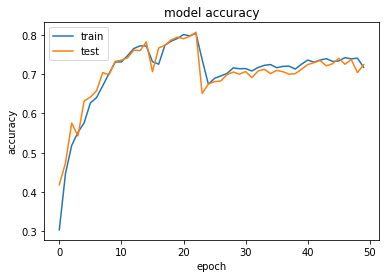

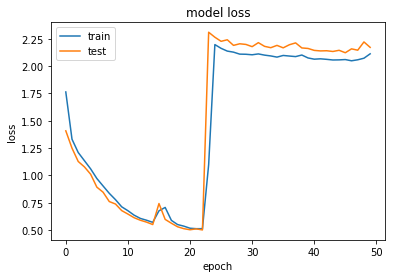

In [44]:
# accuracy plot 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Visualize How CAM activates

In [45]:
#set target wafer number
target_wafer_num = 11
# predict 
prob = model.model.predict(x_test[target_wafer_num].reshape(1,26,26,3))

In [46]:
aver_output = model.model.layers[7]
aver_model = models.Model(input_tensor, aver_output.output)
cam_result = aver_model.predict(x_test[target_wafer_num].reshape(1, 26, 26, 3))

In [47]:
weight_result = model.model.layers[-1].get_weights()[0]

In [48]:
def make_cam(cam_result, weight_result): 
    cam_arr = np.zeros((1,24, 24))
    for row in range(0,9):
        cam = np.zeros((1, 24, 24))
        for i, w in enumerate(weight_result[:, row]):
            cam += (w*cam_result[0,:,:,i]).reshape(24,24)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        cam[mask_x == 0] = 0
        cam_arr = np.concatenate((cam_arr, cam))
    return cam_arr[1:]

def display_activation(cam_arr, prob, wafer): 
    fig, ax = plt.subplots(9, 1, figsize=(50, 50))
    count = 0
    cam_arr[np.percentile(cam_arr, 0.8) > cam_arr] = 0
    for row in range(0,9):
        ax[row].imshow(np.argmax(wafer, axis=2))
        ax[row].imshow(cam_arr[row],cmap='Reds', alpha=0.7)
        ax[row].set_title('class : ' + faulty_case_dict[count]+', prob : {:.4f}'.format(prob[:, count][0]*100) + '%')
        count += 1

In [49]:
faulty_case_dict[np.argmax(y_test[11])]

'Scratch'

faulty case : Scratch


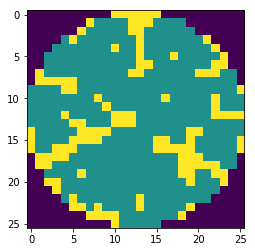

In [50]:
plt.imshow(np.argmax(x_test[target_wafer_num], axis=2))
print('faulty case : {}'.format(faulty_case_dict[np.argmax(y_test[target_wafer_num])]))

In [51]:
cam_result.shape

(1, 24, 24, 256)

In [52]:
cam_arr = make_cam(cam_result, weight_result)

In [53]:
prob.shape

(1, 9)

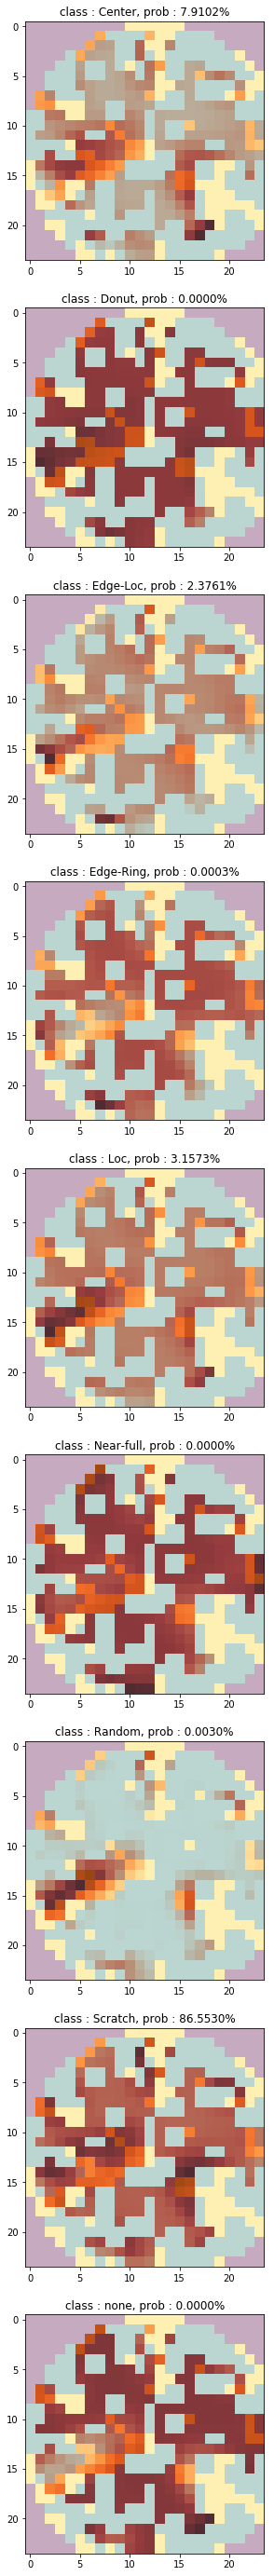

In [54]:
display_activation(cam_arr, prob, x_test[target_wafer_num])